In [36]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [37]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [38]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [39]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
24739,OWID_WRL,NaN,World,2020-06-18,8318148.0,176426.0,450630.0,5250.0,1067.141,22.634,...,5.355,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58
24740,OWID_WRL,NaN,World,2020-06-19,8456815.0,138667.0,456956.0,6326.0,1084.931,17.790,...,5.355,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58
24741,OWID_WRL,NaN,World,2020-06-20,8633778.0,176963.0,462076.0,5120.0,1107.633,22.703,...,5.355,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58


In [40]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [41]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [42]:
## Plotly graph will be not display on Git ##
massBalance("total_deaths",df,"World")
massBalance("total_deaths",df,"France")
massBalance("total_deaths",df,"China")
massBalance("total_deaths",df,"Italy")
massBalance("total_deaths",df,"Spain")
massBalance("total_deaths",df,"United States")
massBalance("total_deaths",df,"Germany")
massBalance("total_deaths",df,"Iran")
massBalance("total_deaths",df,"Turkey")
massBalance("total_deaths",df,"Brazil")

In [43]:
## Plotly graph will be not display on Git ##
massBalance("total_cases",df,"World")
massBalance("total_cases",df,"France")
massBalance("total_cases",df,"China")
massBalance("total_cases",df,"Italy")
massBalance("total_cases",df,"Spain")
massBalance("total_cases",df,"United States")
massBalance("total_cases",df,"United Kingdom")
massBalance("total_cases",df,"Germany")
massBalance("total_cases",df,"Iran")
massBalance("total_cases",df,"Turkey")
massBalance("total_cases",df,"Brazil")

In [44]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [45]:
## Plotly graph will be not display on Git ##
newOverTime("new_cases",df,"World")
newOverTime("new_cases",df,"France")
newOverTime("new_cases",df,"China")
newOverTime("new_cases",df,"Italy")
newOverTime("new_cases",df,"Spain")
newOverTime("new_cases",df,"United States")
newOverTime("new_cases",df,"United Kingdom")
newOverTime("new_cases",df,"Germany")
newOverTime("new_cases",df,"Iran")
newOverTime("new_cases",df,"Turkey")
newOverTime("new_cases",df,"Brazil")

In [46]:
## Plotly graph will be not display on Git ##
newOverTime("new_deaths",df,"World")
newOverTime("new_deaths",df,"France")
newOverTime("new_deaths",df,"China")
newOverTime("new_deaths",df,"Italy")
newOverTime("new_deaths",df,"Spain")
newOverTime("new_deaths",df,"United States")
newOverTime("new_deaths",df,"United Kingdom")
newOverTime("new_deaths",df,"Germany")
newOverTime("new_deaths",df,"Iran")
newOverTime("new_deaths",df,"Turkey")
newOverTime("new_deaths",df,"Brazil")

In [47]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


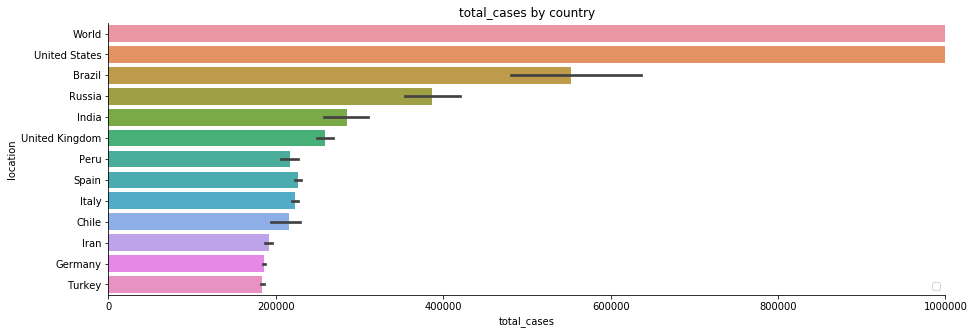

In [48]:
worldrep("total_cases")

No handles with labels found to put in legend.


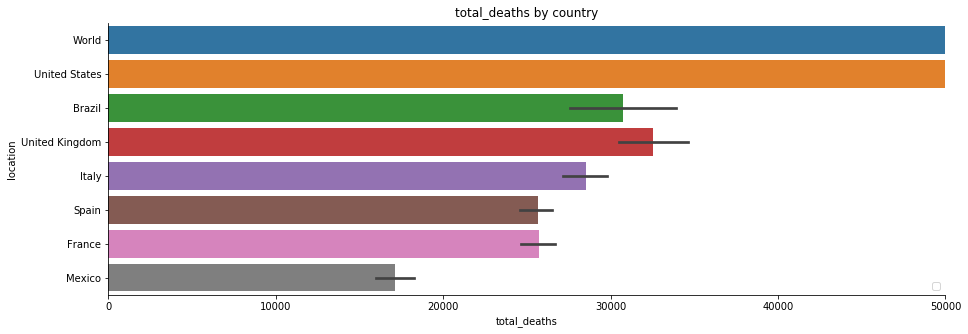

In [49]:
worldrep("total_deaths",val_larg=50000)

In [50]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


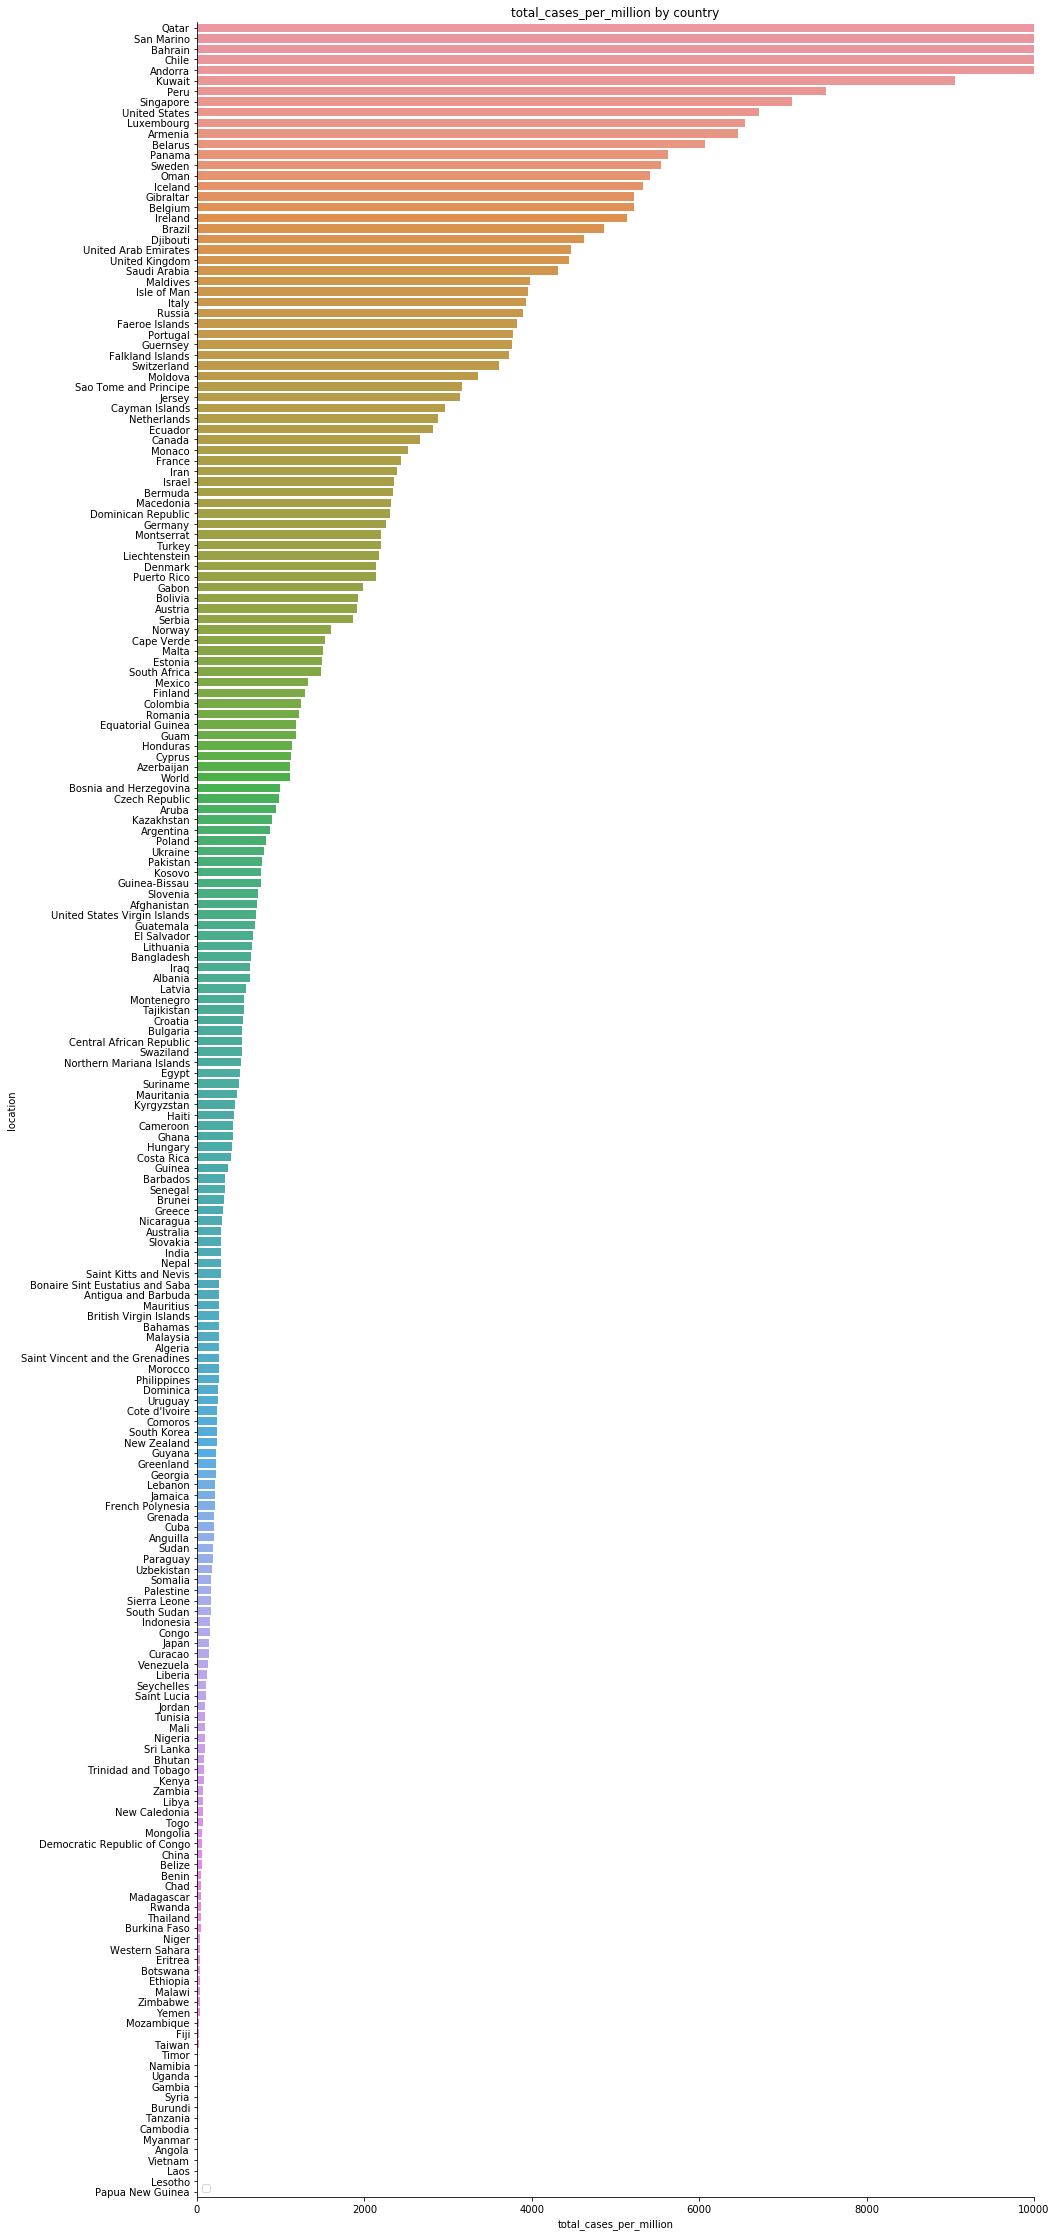

In [51]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


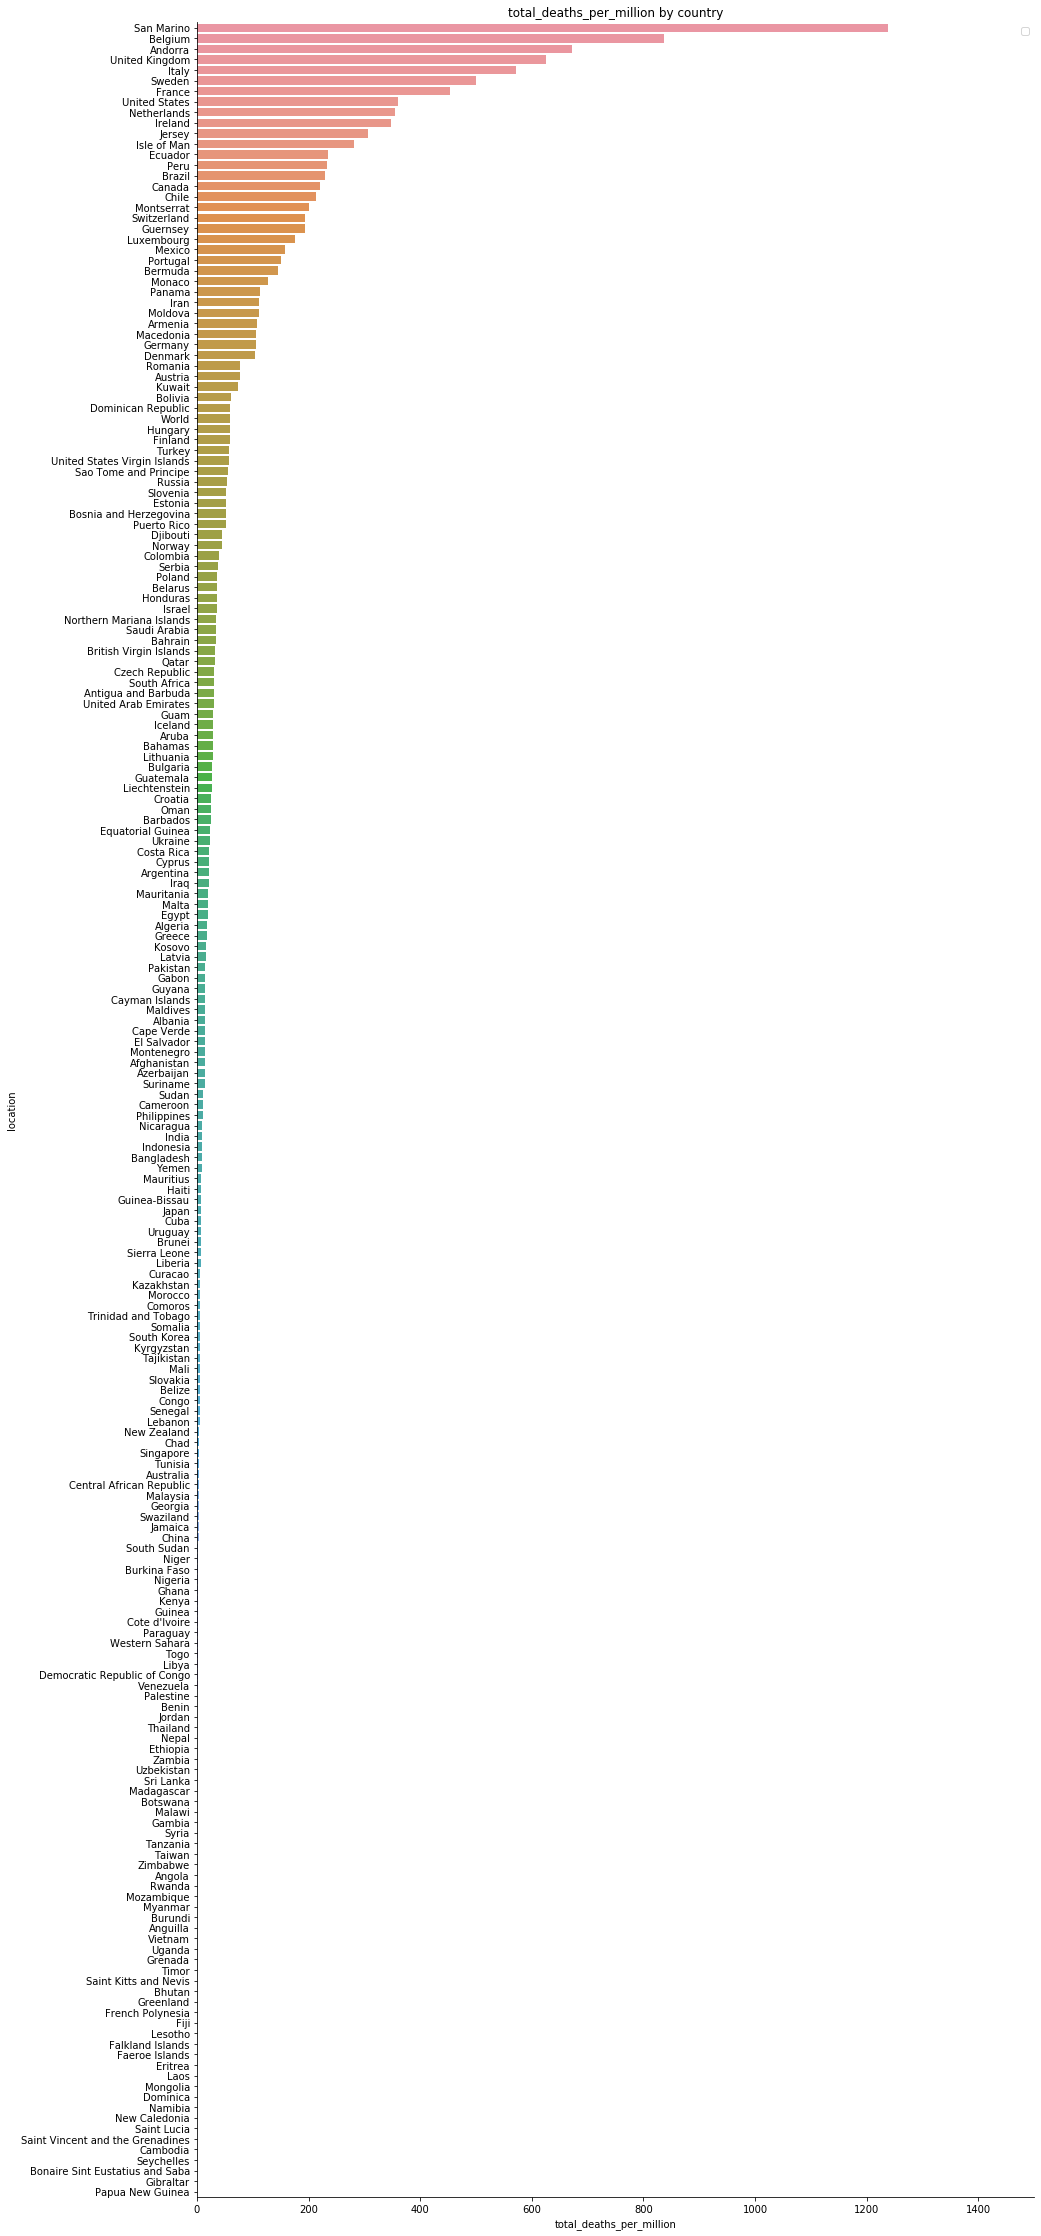

In [52]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

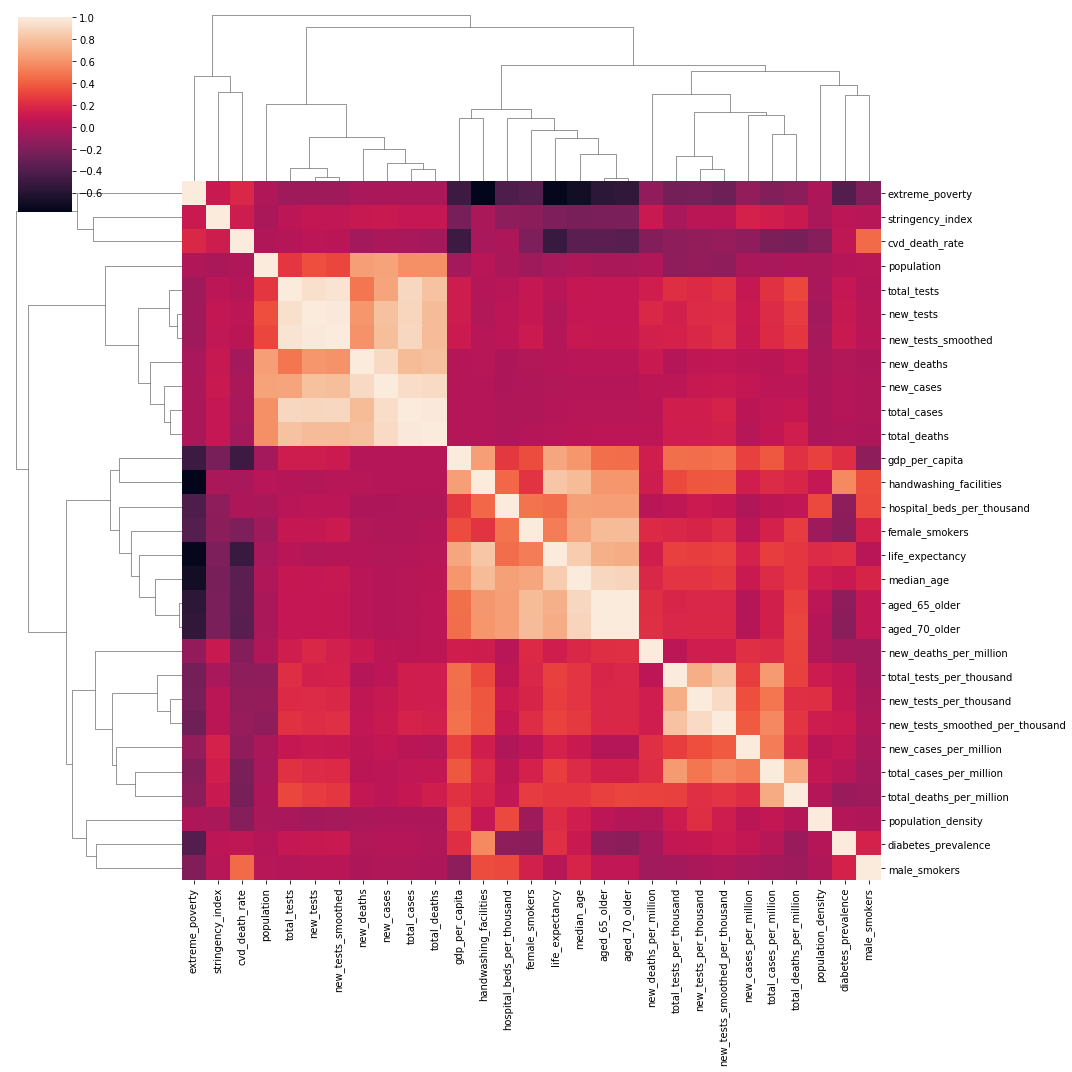

In [53]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [54]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [55]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [56]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [57]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [58]:
periode = 3

In [59]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9975092867295645 (+/- 0.0023613363733515293)
Coef :  [-0.10541561  0.56227686  0.56677906]
3 Last_days :  [[8318148 8456815 8633778]]
Today :  8633778
Prediction + :  157771
Tomorow :  8791549
                                     
--------- Total Death -----------------
                                     
R^2: 0.9975916586684636 (+/- 0.0015185590229287028)
Coef :  [-0.74733086  0.83795667  0.91312491]
3 Last_days :  [[450630 456956 462076]]
Today :  462076
Prediction + :  6497
Tomorow :  468573
                                     


In [60]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8870619023568027 (+/- 0.11746412690329079)
Coef :  [-0.77658326  0.66818382  1.10790703]
3 Last_days :  [[158174 158641 159452]]
Today :  159452
Prediction + :  517
Tomorow :  159969
                                     
--------- Total Death -----------------
                                     
R^2: 0.45874144531805405 (+/- 0.5281000246224035)
Coef :  [-0.73200771  0.57783719  1.15344257]
3 Last_days :  [[29575 29603 29617]]
Today :  29617
Prediction + :  29
Tomorow :  29646
                                     


In [61]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: -6.0722301686531575 (+/- 9.735668434559646)
Coef :  [-0.30746538 -0.05019377  1.35195766]
3 Last_days :  [[84458 84494 84524]]
Today :  84524
Prediction + :  70
Tomorow :  84594
                                     
--------- Total Death -----------------
                                     
R^2: -1431.6979951531014 (+/- 2025.1648439740532)
Coef :  [-0.07249913  0.01216606  1.05361146]
3 Last_days :  [[4638 4638 4638]]
Today :  4638
Prediction + :  12
Tomorow :  4650
                                     


In [62]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8974090889803996 (+/- 0.14303910835994488)
Coef :  [-0.87874277  0.9253396   0.95291163]
3 Last_days :  [[237828 238159 238011]]
Today :  238011
Prediction + :  466
Tomorow :  238477
                                     
--------- Total Death -----------------
                                     
R^2: 0.5157753197602253 (+/- 0.6780628859223214)
Coef :  [-0.87382592  0.92224412  0.9513354 ]
3 Last_days :  [[34448 34514 34561]]
Today :  34561
Prediction + :  86
Tomorow :  34647
                                     


In [63]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.5282407673627437 (+/- 0.6201406920786654)
Coef :  [-0.88087673  0.90739046  0.97274005]
3 Last_days :  [[244683 245268 245575]]
Today :  245575
Prediction + :  618
Tomorow :  246193
                                     
--------- Total Death -----------------
                                     
R^2: 0.5567165785356737 (+/- 0.5570100862697002)
Coef :  [-0.86053392  0.8973827   0.96341047]
3 Last_days :  [[29054 29054 30233]]
Today :  30233
Prediction + :  -2
Tomorow :  30231
                                     


In [64]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.968257410294774 (+/- 0.03491121469789952)
Coef :  [-0.76916802  0.86929683  0.90366916]
3 Last_days :  [[2163290 2191052 2220961]]
Today :  2220961
Prediction + :  29086
Tomorow :  2250047
                                     
--------- Total Death -----------------
                                     
R^2: 0.42714404349788904 (+/- 0.5013855427324766)
Coef :  [-0.80013655  0.84746785  0.95430535]
3 Last_days :  [[117717 118434 119112]]
Today :  119112
Prediction + :  861
Tomorow :  119973
                                     


In [65]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9180017020882955 (+/- 0.06443123091507645)
Coef :  [-0.82516516  0.8786004   0.94768317]
3 Last_days :  [[299251 300469 301815]]
Today :  301815
Prediction + :  1585
Tomorow :  303400
                                     
--------- Total Death -----------------
                                     
R^2: 0.3960562735088 (+/- 0.4934785434977264)
Coef :  [-0.8030193   0.8365087   0.96738012]
3 Last_days :  [[42153 42288 42461]]
Today :  42461
Prediction + :  186
Tomorow :  42647
                                     


In [66]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9374720319962311 (+/- 0.060111097954408776)
Coef :  [-0.85436461  0.88191777  0.97201608]
3 Last_days :  [[187764 188534 189135]]
Today :  189135
Prediction + :  792
Tomorow :  189927
                                     
--------- Total Death -----------------
                                     
R^2: 0.3897214894158723 (+/- 0.4891200630529231)
Coef :  [-0.79917603  0.82074283  0.97868122]
3 Last_days :  [[8856 8872 8883]]
Today :  8883
Prediction + :  25
Tomorow :  8908
                                     


In [67]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.38890027712335345 (+/- 0.8609477528023105)
Coef :  [-0.56850562  0.7668685   0.80962635]
3 Last_days :  [[195051 197647 200262]]
Today :  200262
Prediction + :  2857
Tomorow :  203119
                                     
--------- Total Death -----------------
                                     
R^2: 0.46922702990594684 (+/- 0.7480346049032334)
Coef :  [-0.75472899  0.84620571  0.91078746]
3 Last_days :  [[9185 9272 9392]]
Today :  9392
Prediction + :  88
Tomorow :  9480
                                     


In [68]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.996803700775765 (+/- 0.00274375163413458)
Coef :  [-0.85133404  0.89798174  0.95058835]
3 Last_days :  [[182727 184031 185245]]
Today :  185245
Prediction + :  1222
Tomorow :  186467
                                     
--------- Total Death -----------------
                                     
R^2: 0.9991487977301485 (+/- 0.0006454709698121339)
Coef :  [-0.88852637  0.93395735  0.95195699]
3 Last_days :  [[4861 4882 4905]]
Today :  4905
Prediction + :  20
Tomorow :  4925
                                     


In [69]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.5756685566053871 (+/- 0.593999743320407)
Coef :  [-0.45099846  0.49765119  0.97685955]
3 Last_days :  [[ 955377  978142 1032913]]
Today :  1032913
Prediction + :  32680
Tomorow :  1065593
                                     
--------- Total Death -----------------
                                     
R^2: 0.5693874697521147 (+/- 0.527942775567891)
Coef :  [-0.55255765  0.63256736  0.93529549]
3 Last_days :  [[46510 47748 48954]]
Today :  48954
Prediction + :  1381
Tomorow :  50335
                                     


In [70]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [71]:
model_data

[(8633778, 462076, 8791549, 468573),
 (159452, 29617, 159969, 29646),
 (238011, 34561, 238477, 34647),
 (245575, 30233, 246193, 30231),
 (2220961, 119112, 2250047, 119973),
 (84524, 4638, 84594, 4650),
 (301815, 42461, 303400, 42647),
 (189135, 8883, 189927, 8908),
 (200262, 9392, 203119, 9480),
 (185245, 4905, 186467, 4925),
 (1032913, 48954, 1065593, 50335)]

In [72]:
dump(model_data, "endPoint/CovidDataPred.joblib")

['endPoint/CovidDataPred.joblib']

In [73]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [74]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-06-20,France,159969.0,0.0,29646.0,0.0,0.0,0.0
0,2020-06-20,China,84594.0,0.0,4650.0,0.0,0.0,0.0
0,2020-06-20,Italy,238477.0,0.0,34647.0,0.0,0.0,0.0
0,2020-06-20,Spain,246193.0,0.0,30231.0,0.0,0.0,0.0
0,2020-06-20,United States,2250047.0,0.0,119973.0,0.0,0.0,0.0
0,2020-06-20,World,8791549.0,0.0,468573.0,0.0,0.0,0.0
0,2020-06-20,United Kingdom,303400.0,0.0,42647.0,0.0,0.0,0.0
0,2020-06-20,Germany,189927.0,0.0,8908.0,0.0,0.0,0.0
0,2020-06-20,Iran,203119.0,0.0,9480.0,0.0,0.0,0.0
0,2020-06-20,Turkey,186467.0,0.0,4925.0,0.0,0.0,0.0


In [75]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")